# Analyse et Prévision de la Consommation, Contribution et Production des Produits Halieutiques


## Introduction

Dans ce notebook, nous allons analyser et prédire la consommation, la contribution nutritionnelle et la production des produits halieutiques au Maroc. Nous utiliserons le modèle ARIMA pour effectuer les prévisions jusqu'à l'année 2030. Les étapes suivantes seront suivies pour chaque série de données :

1. Chargement et exploration des données.
2. Analyse de la stationnarité des données.
3. Préparation et ajustement du modèle ARIMA.
4. Prévision des valeurs futures.
5. Visualisation des résultats.
6. Analyse comparative pour prédire la demande sur le marché interne du Maroc.

## Importation des bibliothèques nécessaires

In [1900]:
pip install pmdarima

In [1901]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

## Étude de la Consommation

### 1. Chargement et Exploration des Données
Nous allons commencer par charger les données de consommation.


   Année  Consommation
0   1990          7.62
1   1991          7.21
2   1992          8.93
3   1993          7.82
4   1994          8.93
5   1995          7.62
6   1996          6.41
7   1997          7.11
8   1998          6.91
9   1999          7.72
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Année         26 non-null     int64  
 1   Consommation  26 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 544.0 bytes
None


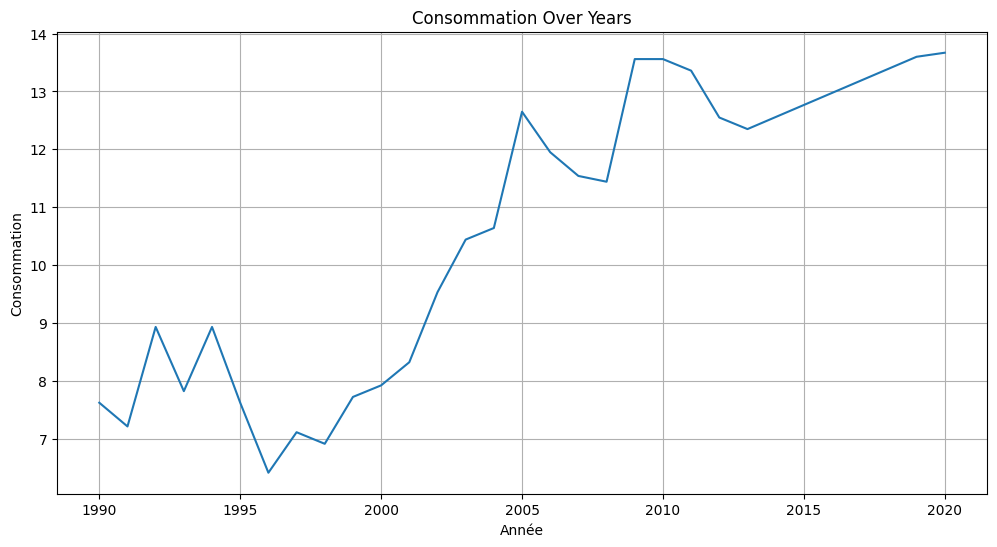

In [1902]:
# Charger les données
df = pd.read_csv("/content/cleaned_consommation.csv")

# Afficher les premières lignes et les infos du DataFrame
print(df.head(10))
print(df.info())

# Définir l'index du DataFrame sur la colonne 'Année'
df.set_index('Année', inplace=True)

# Visualiser les données
df['Consommation'].plot(figsize=(12, 6))
plt.title('Consommation Over Years')
plt.xlabel('Année')
plt.ylabel('Consommation')
plt.grid(True)
plt.show()

 ### 2. Analyse de la Stationnarité des Données
 Nous allons utiliser le test KPSS pour vérifier si les données sont stationnaires.


In [1903]:
# Effectuer le test KPSS pour vérifier la stationnarité
kpss_result = kpss(df['Consommation'], regression='c', nlags="auto")
print('\nKPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'{key}: {value}')

alpha = 0.05  # Niveau de signification de 5%

if kpss_result[1] <= alpha:
    print("Rejeter l'hypothèse nulle (H0) du test KPSS. Les données ne sont donc pas stationnaires.")
else:
    print("Ne pas rejeter l'hypothèse nulle (H0) du test KPSS. Les données sont donc stationnaires.")


KPSS Statistic: 0.6732532511453359
p-value: 0.01597697716860583
Critical Values:
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739
Rejeter l'hypothèse nulle (H0) du test KPSS. Les données ne sont donc pas stationnaires.


Rejeter l'hypothèse nulle (H0) du test KPSS. Les données ne sont donc pas stationnaires.


In [1904]:
# Perform the Augmented Dickey-Fuller test
result = adfuller(df['Consommation'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpretation
if result[1] > 0.05:
    print("The time series is non-stationary.")
else:
    print("The time series is stationary.")

ADF Statistic: -0.6749360150571951
p-value: 0.8531353061220414
Critical Values:
   1%: -3.7238633119999998
   5%: -2.98648896
   10%: -2.6328004
The time series is non-stationary.


### 3. Préparation et Ajustement du Modèle ARIMA
Nous allons utiliser auto_arima pour trouver les meilleurs paramètres du modèle ARIMA, puis ajuster le modèle et effectuer des prévisions.

#### Diviser les données en ensembles d'entraînement et de test basés sur l'année 2008


       Consommation
Année              
1990           7.62
1991           7.21
1992           8.93
1993           7.82
1994           8.93
1995           7.62
1996           6.41
1997           7.11
1998           6.91
1999           7.72
2000           7.92
2001           8.32
2002           9.53
2003          10.44
2004          10.64
2005          12.65
2006          11.95
2007          11.54
2008          11.44
2009          13.56
2010          13.56
2011          13.36
2012          12.55
2013          12.35
       Consommation
Année              
2013          12.35
2019          13.60
2020          13.67


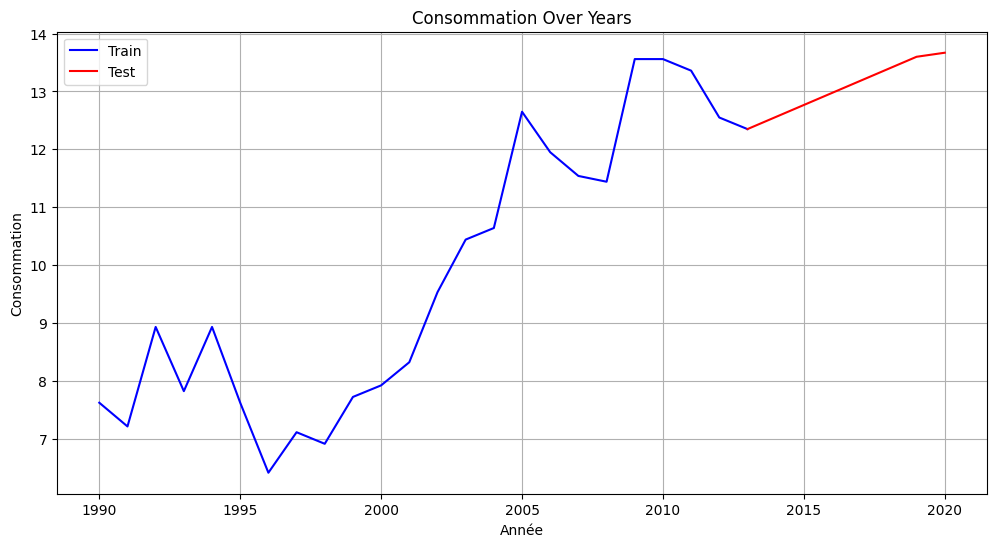

In [1905]:
# Diviser les données en ensembles d'entraînement et de test basés sur l'année 2009
train_df = df[df.index <= 2013]
test_df = df[df.index >= 2013]

print(train_df)
print(test_df)

# Visualiser les ensembles d'entraînement et de test
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['Consommation'], 'b', label='Train') # Bleu
plt.plot(test_df.index, test_df['Consommation'], 'r', label='Test') # Rouge
plt.xlabel('Année')
plt.ylabel('Consommation')
plt.title('Consommation Over Years')
plt.legend()
plt.grid(True)
plt.show()

#### Utiliser auto_arima pour trouver le meilleur modèle ARIMA

In [1906]:
# Utiliser auto_arima pour trouver le meilleur modèle ARIMA avec une recherche exhaustive
stepwise_fit = auto_arima(df['Consommation'],
                          start_p=0, max_p=5,  # Plage de recherche pour p
                          start_q=0, max_q=5,  # Plage de recherche pour q
                          start_d=0, max_d=2,  # Plage de recherche pour d
                          d=None,  # auto_arima déterminera la meilleure valeur pour d
                          seasonal=False,  # Ne pas inclure de composante saisonnière
                          stepwise=False,  # Utiliser une recherche exhaustive
                          trace=True,  # Afficher les résultats de chaque étape
                          suppress_warnings=True,  # Supprimer les avertissements
                          information_criterion='aic')  # Utiliser AIC pour la sélection du modèle

# Afficher le résumé du modèle auto_arima
print(stepwise_fit.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.348, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=73.011, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=75.009, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=79.492, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=73.010, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=74.968, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=75.006, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=76.374, Time=0.04 sec


In [1907]:
# Former le modèle ARIMA en utilisant les meilleurs paramètres trouvés par auto_arima
model = ARIMA(train_df['Consommation'], order=(2, 1, 4)) # Ici, nous avons choisi un autre ordre, car auto-arima ne parcourt pas toutes les combinaisons possibles !
model_fit = model.fit()
print(model_fit.summary())

# Faire des prédictions pour l'ensemble de test
predictions = model_fit.forecast(steps=len(test_df))

# Calculer le RMSE
rmse = sqrt(mean_squared_error(test_df['Consommation'], predictions))
print(f'Root Mean Squared Error: {rmse}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                               SARIMAX Results                                
Dep. Variable:           Consommation   No. Observations:                   24
Model:                 ARIMA(2, 1, 4)   Log Likelihood                 -30.310
Date:                Wed, 22 May 2024   AIC                             74.620
Time:                        23:52:52   BIC                             82.568
Sample:                             0   HQIC                            76.619
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8478      0.348      2.434      0.015       0.165       1.530
ar.L2         -0.9563      0.550     -1.740      0.082      -2.033       0.121
ma.L1         -1.1500      8.511     -0.135      0.8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(




#### Visualiser les données originales, les données d'entraînement, les données de test et les prédictions


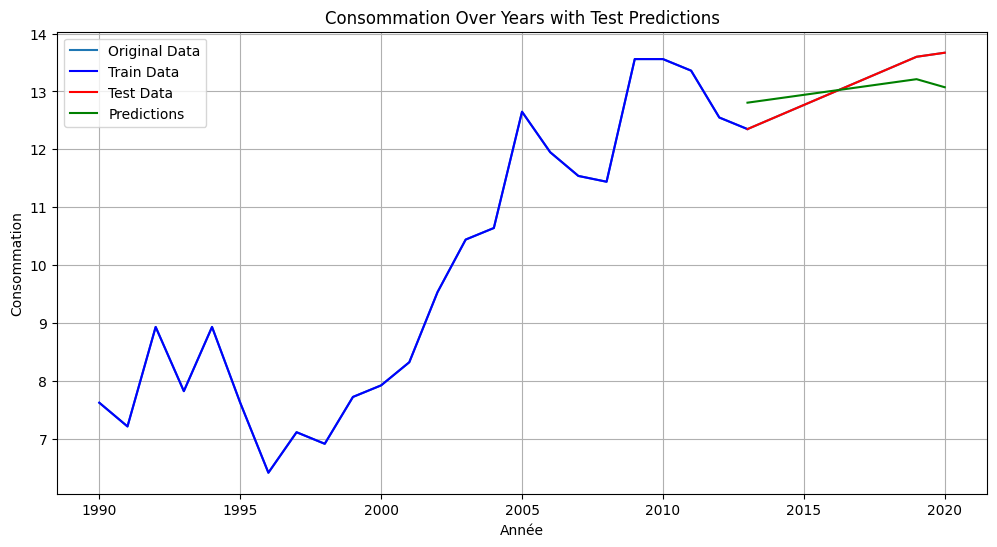

In [1908]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Consommation'], label='Original Data')
plt.plot(train_df.index, train_df['Consommation'], label='Train Data', color='blue')
plt.plot(test_df.index, test_df['Consommation'], label='Test Data', color='red')
plt.plot(test_df.index, predictions, label='Predictions', color='green')
plt.xlabel('Année')
plt.ylabel('Consommation')
plt.title('Consommation Over Years with Test Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [1909]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculer le RMSE
rmse = sqrt(mean_squared_error(test_df['Consommation'], predictions))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.48800377616231794


### 4. Prévisions Futures
Nous allons effectuer des prévisions futures jusqu'en 2030.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


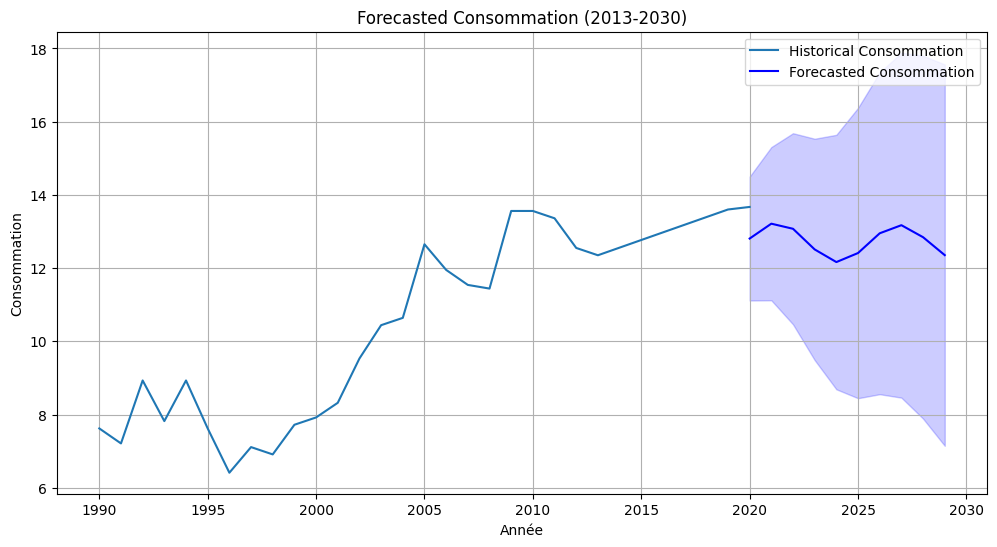

In [1910]:
# Prévisions futures jusqu'en 2030
forecast_steps = 2030 - 2020
arima_full_forecast = model_fit.get_forecast(steps=forecast_steps)
future_pred = arima_full_forecast.predicted_mean
future_conf_int = arima_full_forecast.conf_int()

future_index = pd.RangeIndex(start=2020, stop=2020 + forecast_steps, step=1)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Consommation'], label='Historical Consommation')
plt.plot(future_index, future_pred, label='Forecasted Consommation', color='blue')
plt.fill_between(future_index, future_conf_int.iloc[:, 0], future_conf_int.iloc[:, 1], color='blue', alpha=0.2)
plt.xlabel('Année')
plt.ylabel('Consommation')
plt.title('Forecasted Consommation (2013-2030)')
plt.legend()
plt.grid(True)
plt.show()

##Étude de la Contribution Nutritionnelle
Répétons les mêmes étapes pour la contribution nutritionnelle.




### 1. Chargement et Exploration des Données


   Année  Pourcentage
0   1980        23.72
1   1981        22.63
2   1982        22.33
3   1983        23.36
4   1984        23.89
5   1985        27.35
6   1986        24.50
7   1987        19.48
8   1988        15.03
9   1989        14.75
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Année        32 non-null     int64  
 1   Pourcentage  32 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 640.0 bytes
None
Data types before conversion:
 Année            int64
Pourcentage    float64
dtype: object
Data types after conversion:
 Année            int64
Pourcentage    float64
dtype: object


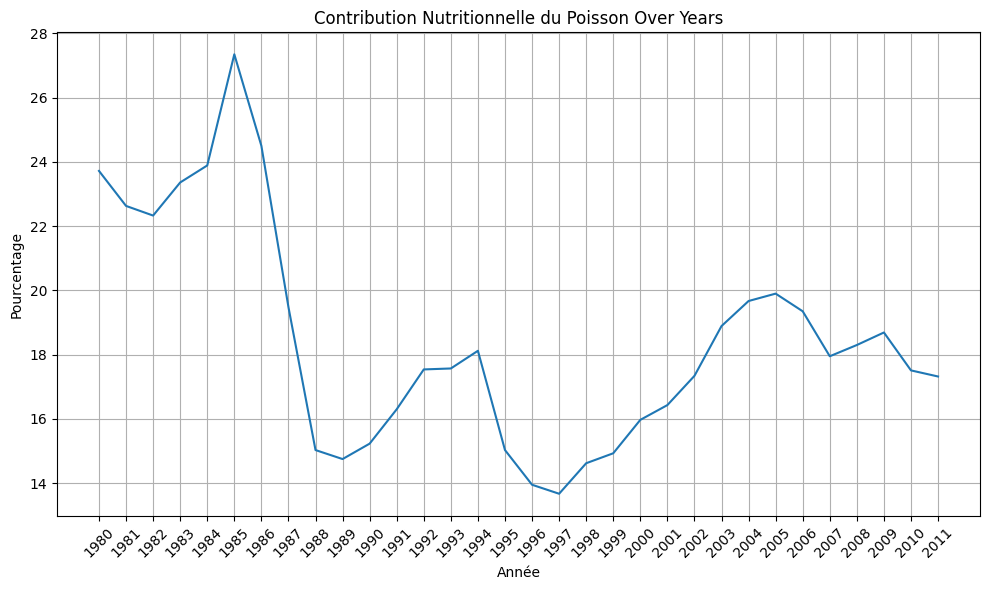

In [1911]:
# Lire le fichier CSV
df = pd.read_csv("/content/cleaned_contribution.csv")

# Afficher les premières lignes et les informations du DataFrame
print(df.head(10))
print(df.info())

# Vérifier les types de données et les convertir si nécessaire
print("Data types before conversion:\n", df.dtypes)
df['Année'] = df['Année'].astype(int)
df['Pourcentage'] = df['Pourcentage'].astype(float)
print("Data types after conversion:\n", df.dtypes)

# Visualiser les données avec un graphique en ligne
plt.figure(figsize=(10, 6))
plt.plot(df['Année'], df['Pourcentage'])
plt.title('Contribution Nutritionnelle du Poisson Over Years')
plt.xlabel('Année')
plt.ylabel('Pourcentage')
plt.grid(True)
plt.xticks(df['Année'], rotation=45)
plt.tight_layout()
plt.show()

In [1912]:
df.set_index('Année', inplace=True)

In [1913]:
df.head()

,Pourcentage
Année,
1980,23.72
1981,22.63
1982,22.33
1983,23.36
1984,23.89


### 2. Analyse de la Stationnarité des Données


In [1914]:
# Effectuer le test KPSS pour vérifier la stationnarité
kpss_result = kpss(df['Pourcentage'], regression='c', nlags="auto")
print('\nKPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'{key}: {value}')

alpha = 0.05  # Niveau de signification de 5%

if kpss_result[1] <= alpha:
    print("Rejeter l'hypothèse nulle (H0) du test KPSS. Les données ne sont donc pas stationnaires.")
else:
    print("Ne pas rejeter l'hypothèse nulle (H0) du test KPSS. Les données sont donc stationnaires.")


KPSS Statistic: 0.3327694198360711
p-value: 0.1
Critical Values:
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739
Ne pas rejeter l'hypothèse nulle (H0) du test KPSS. Les données sont donc stationnaires.


<ipython-input-1914-19cf9419cb12>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df['Pourcentage'], regression='c', nlags="auto")


### 3. Préparation et Ajustement du Modèle ARIMA


#### Diviser les données en ensembles d'entraînement et de test basés sur l'année 2009


       Pourcentage
Année             
1980         23.72
1981         22.63
1982         22.33
1983         23.36
1984         23.89
1985         27.35
1986         24.50
1987         19.48
1988         15.03
1989         14.75
1990         15.23
1991         16.30
1992         17.54
1993         17.57
1994         18.12
1995         15.03
1996         13.95
1997         13.67
1998         14.62
1999         14.93
2000         15.97
2001         16.43
2002         17.34
2003         18.89
2004         19.67
2005         19.90
2006         19.35
2007         17.95
       Pourcentage
Année             
2007         17.95
2008         18.30
2009         18.69
2010         17.51
2011         17.32


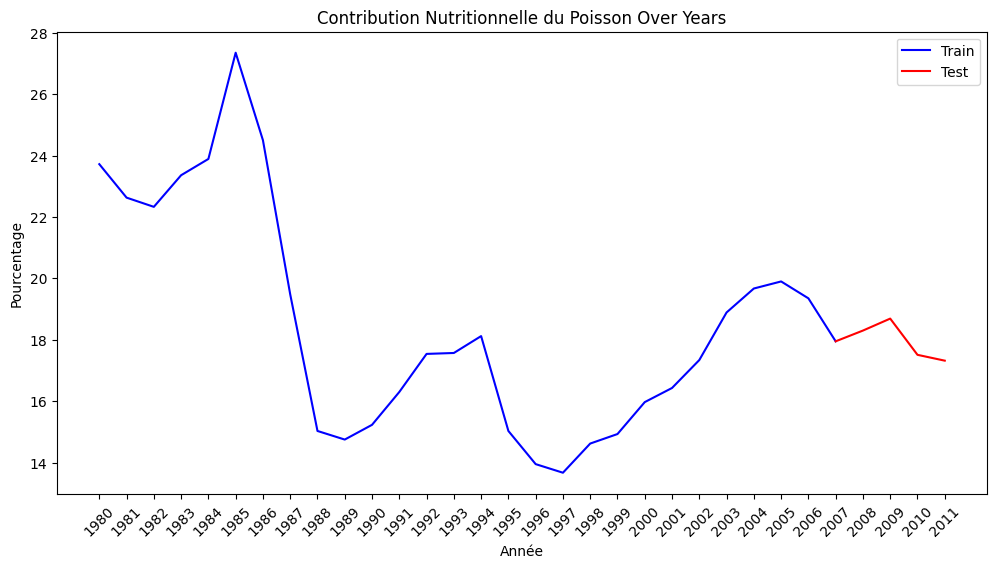

In [1915]:
# Split into train and test
train_df = df[df.index <= 2007]
test_df = df[df.index >= 2007]

print(train_df)
print(test_df)

# Plot the train and test data
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['Pourcentage'], 'b', label='Train') # Blue
plt.plot(test_df.index, test_df['Pourcentage'], 'r', label='Test') # Red
plt.xlabel('Année')
plt.ylabel('Pourcentage')
plt.title('Contribution Nutritionnelle du Poisson Over Years')
plt.xticks(df.index, rotation=45)
plt.legend()
plt.show()

#### Utiliser auto_arima pour trouver le meilleur modèle ARIMA

In [1916]:
# Utiliser auto_arima pour trouver le meilleur modèle ARIMA
stepwise_fit = auto_arima(df['Pourcentage'], trace=True, suppress_warnings=True)


# Afficher le résumé du modèle auto_arima
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=126.521, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=173.428, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=131.055, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=145.470, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=280.551, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=124.650, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=126.143, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=126.443, Time=0.24 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=126.005, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=126.215, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=130.589, Time=0.06 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 1.526 seconds
                               SARIMAX Resu

In [1917]:
# Former le modèle ARIMA en utilisant les meilleurs paramètres trouvés par auto_arima
model = ARIMA(train_df['Pourcentage'], order=(1, 0, 2)) # l'auto-arima justifie donc le fait que les données sont stationnaires, en prenant 0 dans la valeur de d (différenciation).
model_fit = model.fit()
print(model_fit.summary())

# Faire des prédictions pour l'ensemble de test
predictions = model_fit.forecast(steps=len(test_df))

# Calculer le RMSE
rmse = sqrt(mean_squared_error(test_df['Pourcentage'], predictions))
print(f'Root Mean Squared Error: {rmse}')

                               SARIMAX Results                                
Dep. Variable:            Pourcentage   No. Observations:                   28
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 -51.302
Date:                Wed, 22 May 2024   AIC                            112.605
Time:                        23:52:55   BIC                            119.266
Sample:                             0   HQIC                           114.641
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.9770      2.179      8.707      0.000      14.705      23.249
ar.L1          0.6950      0.208      3.335      0.001       0.287       1.103
ma.L1          0.6811      0.278      2.451      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

### 4. Visualisation des Résultats
 Visualiser les données originales, les données d'entraînement, les données de test et les prédictions



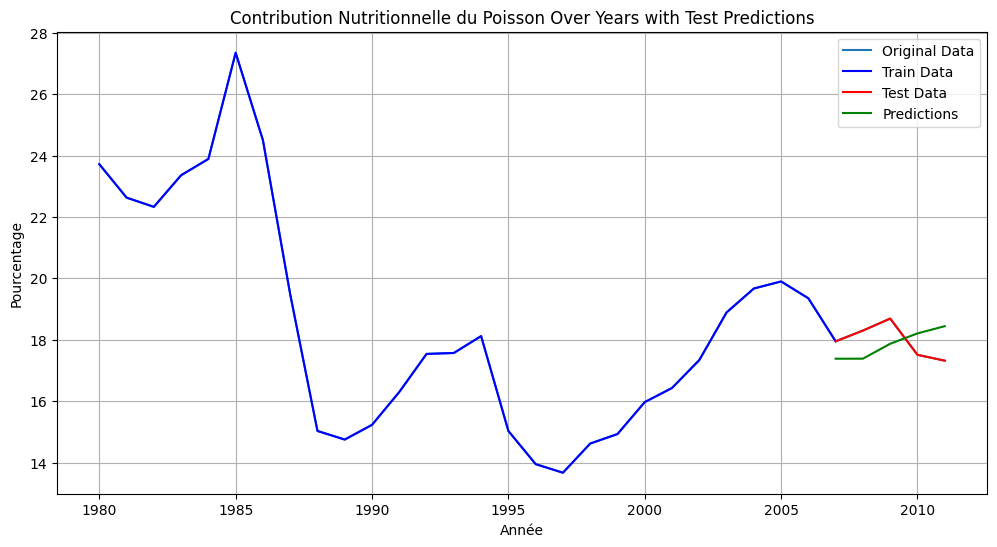

In [1918]:
# Visualiser les données originales, les données d'entraînement, les données de test et les prédictions
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Pourcentage'], label='Original Data')
plt.plot(train_df.index, train_df['Pourcentage'], label='Train Data', color='blue')
plt.plot(test_df.index, test_df['Pourcentage'], label='Test Data', color='red')
plt.plot(test_df.index, predictions, label='Predictions', color='green')
plt.xlabel('Année')
plt.ylabel('Pourcentage')
plt.title('Contribution Nutritionnelle du Poisson Over Years with Test Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [1919]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculer le RMSE
rmse = sqrt(mean_squared_error(test_df['Pourcentage'], predictions))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.8458738647928694


### 5. Prévisions Futures


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


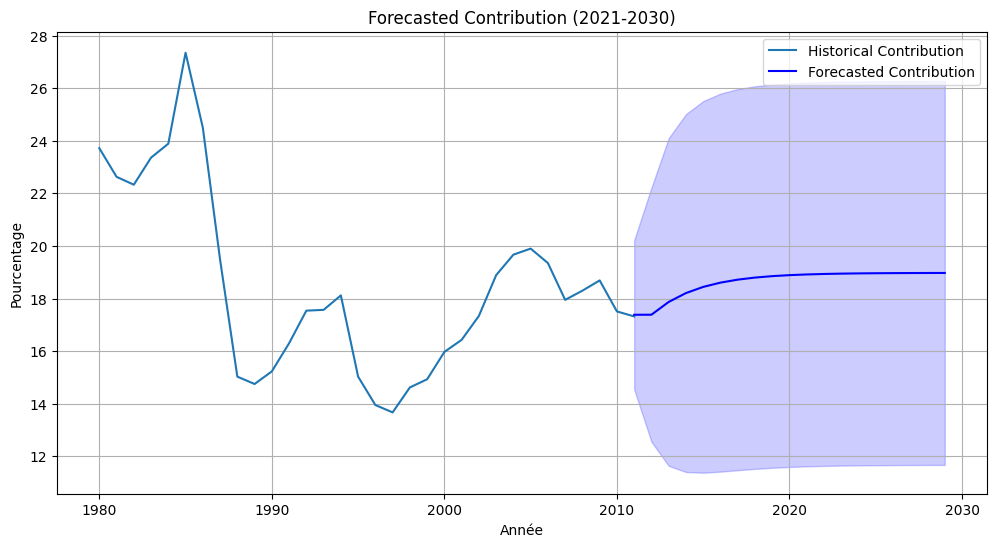

In [1920]:
# Prévisions futures jusqu'en 2030
forecast_steps = 2030 - 2011
arima_full_forecast = model_fit.get_forecast(steps=forecast_steps)
future_pred = arima_full_forecast.predicted_mean
future_conf_int = arima_full_forecast.conf_int()

future_index = pd.RangeIndex(start=2011, stop=2011 + forecast_steps, step=1)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Pourcentage'], label='Historical Contribution')
plt.plot(future_index, future_pred, label='Forecasted Contribution', color='blue')
plt.fill_between(future_index, future_conf_int.iloc[:, 0], future_conf_int.iloc[:, 1], color='blue', alpha=0.2)
plt.xlabel('Année')
plt.ylabel('Pourcentage')
plt.title('Forecasted Contribution (2021-2030)')
plt.legend()
plt.grid(True)
plt.show()

## Étude de la Production
Répétons les mêmes étapes pour la production.




### 1. Chargement et Exploration des Données


   Année  Production
0   1980     4976.83
1   1981     4234.21
2   1982     3885.81
3   1983     3596.74
4   1984     3221.81
5   1985     3288.62
6   1986     3204.70
7   1987     3345.88
8   1988     3121.45
9   1989     3343.64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Année       35 non-null     int64  
 1   Production  35 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 688.0 bytes
None


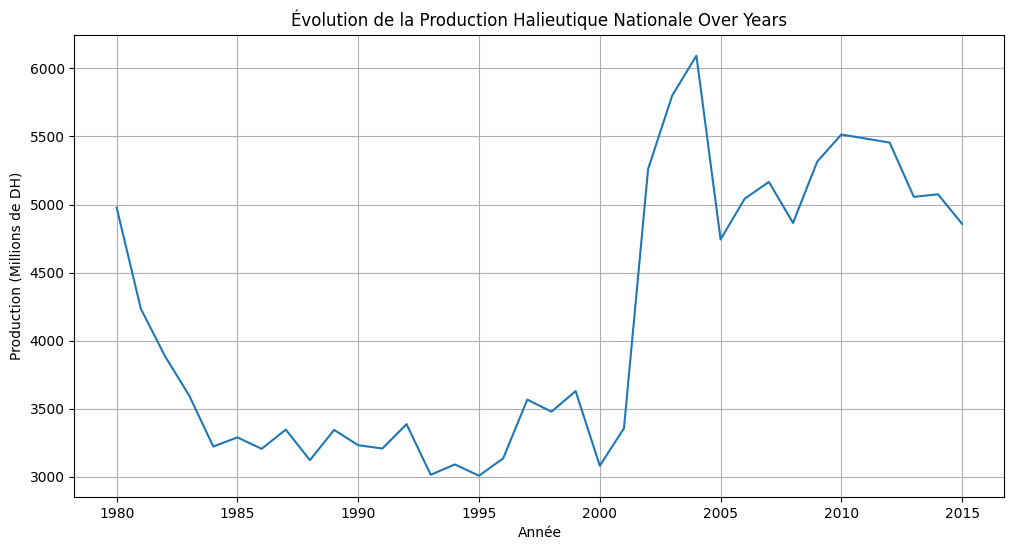

In [1921]:
# Charger les données
df = pd.read_csv("/content/cleaned_production.csv")

# Afficher les premières lignes et les infos du DataFrame
print(df.head(10))
print(df.info())

# Définir l'index du DataFrame sur la colonne 'Année'
df.set_index('Année', inplace=True)

# Visualiser les données
df['Production'].plot(figsize=(12, 6))
plt.title('Évolution de la Production Halieutique Nationale Over Years')
plt.xlabel('Année')
plt.ylabel('Production (Millions de DH)')
plt.grid(True)
plt.show()

###2. Analyse de la Stationnarité des Données


In [1922]:
# Effectuer le test KPSS pour vérifier la stationnarité
kpss_result = kpss(df['Production'], regression='c', nlags="auto")
print('\nKPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'{key}: {value}')

alpha = 0.05  # Niveau de signification de 5%

if kpss_result[1] <= alpha:
    print("Rejeter l'hypothèse nulle (H0) du test KPSS. Les données ne sont donc pas stationnaires.")
else:
    print("Ne pas rejeter l'hypothèse nulle (H0) du test KPSS. Les données sont donc stationnaires.")



KPSS Statistic: 0.5879148276485977
p-value: 0.0237350156683093
Critical Values:
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739
Rejeter l'hypothèse nulle (H0) du test KPSS. Les données ne sont donc pas stationnaires.


In [1923]:
# Perform the Augmented Dickey-Fuller test
result = adfuller(df['Production'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpretation
if result[1] > 0.05:
    print("The time series is non-stationary.")
else:
    print("The time series is stationary.")

ADF Statistic: -1.5118002889775104
p-value: 0.5276660380944511
Critical Values:
   1%: -3.639224104416853
   5%: -2.9512301791166293
   10%: -2.614446989619377
The time series is non-stationary.


### 3. Préparation et Ajustement du Modèle ARIMA


#### Diviser les données en ensembles d'entraînement et de test basés sur l'année 2008


       Production
Année            
1980      4976.83
1981      4234.21
1982      3885.81
1983      3596.74
1984      3221.81
1985      3288.62
1986      3204.70
1987      3345.88
1988      3121.45
1989      3343.64
1990      3231.23
1991      3207.01
1992      3385.99
1993      3014.06
1994      3089.92
1995      3007.06
1996      3134.66
1997      3566.41
1998      3477.53
1999      3628.91
2000      3080.41
2001      3355.33
2002      5261.14
2003      5801.95
2004      6093.35
2005      4743.24
2006      5043.06
2007      5165.99
2008      4864.45
       Production
Année            
2008      4864.45
2009      5314.87
2010      5514.32
2012      5455.09
2013      5056.25
2014      5074.94
2015      4857.47


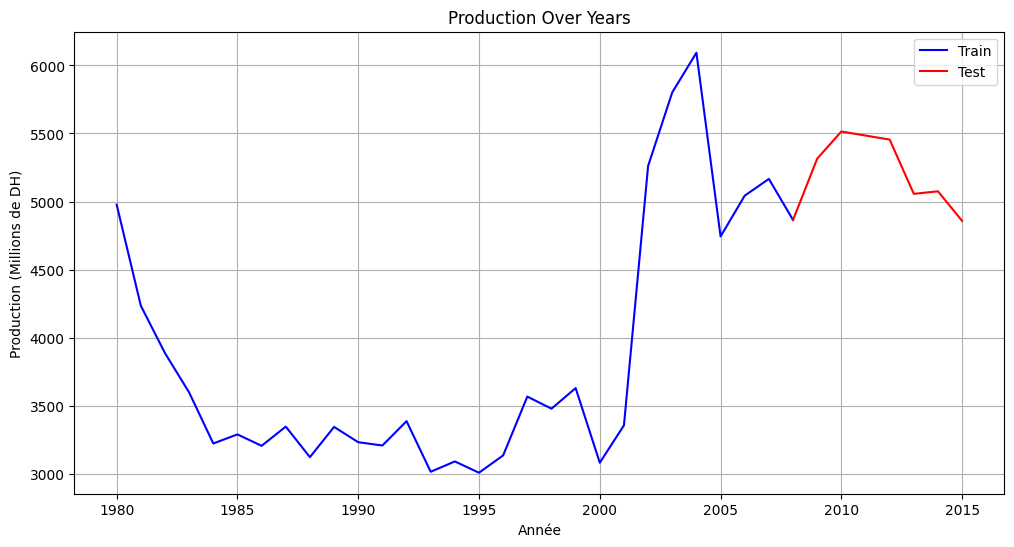

In [1924]:
# Diviser les données en ensembles d'entraînement et de test basés sur l'année 2009
train_df = df[df.index <= 2008]
test_df = df[df.index >= 2008]

print(train_df)
print(test_df)

# Visualiser les ensembles d'entraînement et de test
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['Production'], 'b', label='Train') # Bleu
plt.plot(test_df.index, test_df['Production'], 'r', label='Test') # Rouge
plt.xlabel('Année')
plt.ylabel('Production (Millions de DH)')
plt.title('Production Over Years')
plt.legend()
plt.grid(True)
plt.show()

#### # Utiliser auto_arima pour trouver le meilleur modèle ARIMA


In [1925]:
# Utiliser auto_arima pour trouver le meilleur modèle ARIMA avec une recherche exhaustive
# Utiliser auto_arima pour trouver le meilleur modèle ARIMA avec une recherche exhaustive
stepwise_fit = auto_arima(df['Production'],
                          start_p=0, max_p=5,  # Plage de recherche pour p
                          start_q=0, max_q=5,  # Plage de recherche pour q
                          start_d=0, max_d=2,  # Plage de recherche pour d
                          d=None,  # auto_arima déterminera la meilleure valeur pour d
                          seasonal=False,  # Ne pas inclure de composante saisonnière
                          stepwise=False,  # Utiliser une recherche exhaustive
                          trace=True,  # Afficher les résultats de chaque étape
                          n_jobs=-1,  # Utiliser tous les cœurs disponibles pour accélérer la recherche
                          suppress_warnings=True,  # Supprimer les avertissements
                          information_criterion='aic')  # Utiliser AIC pour la sélection du modèle

# Afficher le résumé du modèle auto_arima
print(stepwise_fit.summary())


Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.940 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   35
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -259.167
Date:                Wed, 22 May 2024   AIC                            522.333
Time:                        23:52:59   BIC                            525.386
Sample:                             0   HQIC                           523.374
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.5106     91.162     -0.039      0.969    -182.185     175.164
sigma2      2.446e+05    3.3e+04      7.421      0.000

In [1926]:
# Former le modèle ARIMA en utilisant les meilleurs paramètres trouvés par auto_arima
model = ARIMA(train_df['Production'], order=(5, 1, 2)) # Ajustement manuelle, en se basant sur plusieurs tests... (approche bruteforce)
model_fit = model.fit()
print(model_fit.summary())

# Faire des prédictions pour l'ensemble de test
predictions = model_fit.forecast(steps=len(test_df))

# Calculer le RMSE
rmse = sqrt(mean_squared_error(test_df['Production'], predictions))
print(f'Root Mean Squared Error: {rmse}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                   29
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -211.029
Date:                Wed, 22 May 2024   AIC                            438.057
Time:                        23:53:00   BIC                            448.715
Sample:                             0   HQIC                           441.315
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4745      0.648     -2.274      0.023      -2.745      -0.204
ar.L2         -0.8306      0.541     -1.536      0.125      -1.890       0.229
ar.L3         -0.3699      0.463     -0.799      0.4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


###4. Visualisation des Résultats
 Visualiser les données originales, les données d'entraînement, les données de test et les prédictions



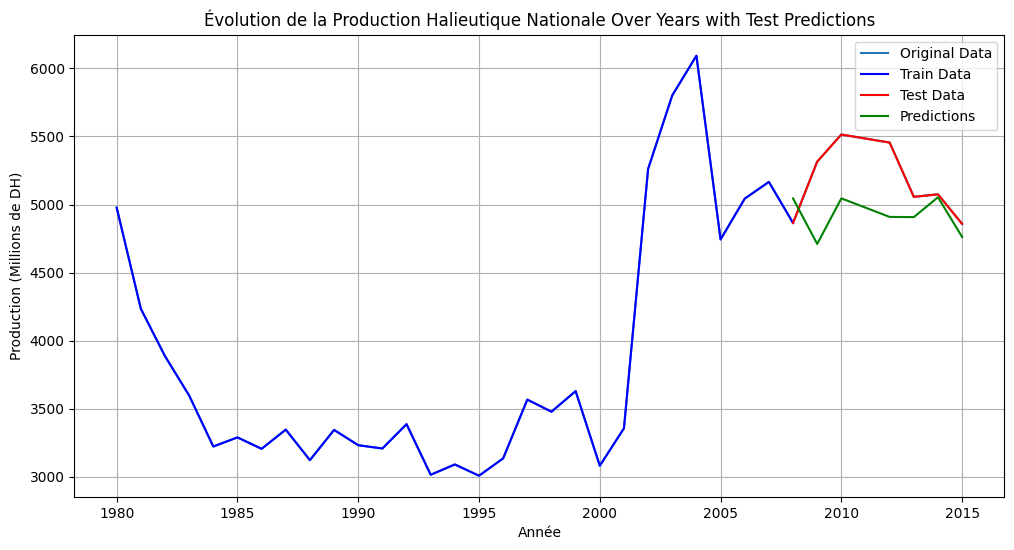

In [1896]:
# Visualiser les données originales, les données d'entraînement, les données de test et les prédictions
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Production'], label='Original Data')
plt.plot(train_df.index, train_df['Production'], label='Train Data', color='blue')
plt.plot(test_df.index, test_df['Production'], label='Test Data', color='red')
plt.plot(test_df.index, predictions, label='Predictions', color='green')
plt.xlabel('Année')
plt.ylabel('Production (Millions de DH)')
plt.title('Évolution de la Production Halieutique Nationale Over Years with Test Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [1897]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculer le RMSE
rmse = sqrt(mean_squared_error(test_df['Production'], predictions))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 368.11716536314987


### 4. Prévisions Futures


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


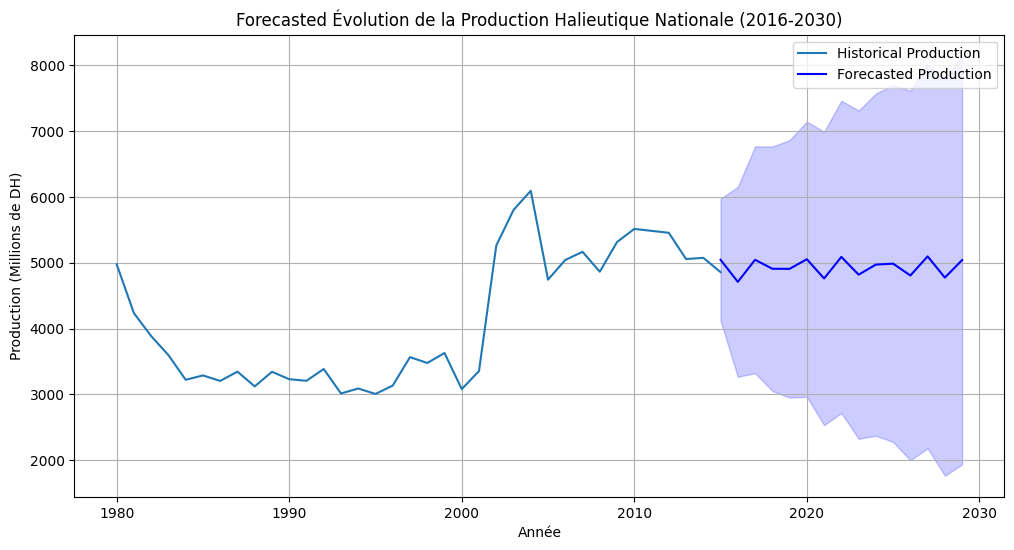

In [1898]:
# Prévisions futures jusqu'en 2030
forecast_steps = 2030 - 2015
arima_full_forecast = model_fit.get_forecast(steps=forecast_steps)
future_pred = arima_full_forecast.predicted_mean
future_conf_int = arima_full_forecast.conf_int()

future_index = pd.RangeIndex(start=2015, stop=2015 + forecast_steps, step=1)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Production'], label='Historical Production')
plt.plot(future_index, future_pred, label='Forecasted Production', color='blue')
plt.fill_between(future_index, future_conf_int.iloc[:, 0], future_conf_int.iloc[:, 1], color='blue', alpha=0.2)
plt.xlabel('Année')
plt.ylabel('Production (Millions de DH)')
plt.title('Forecasted Évolution de la Production Halieutique Nationale (2016-2030)')
plt.legend()
plt.grid(True)
plt.show()


### Utilisation RNN (LSTM) pour la prédiction

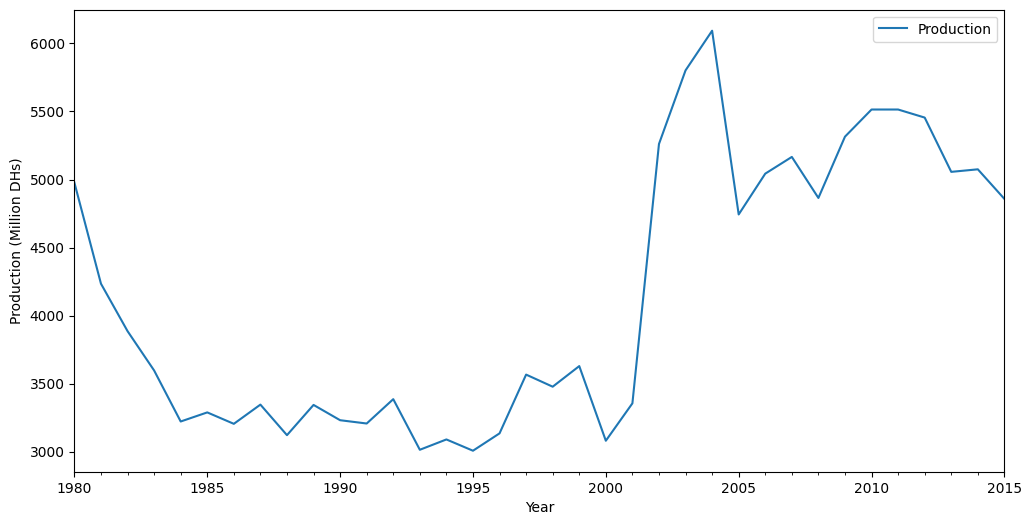

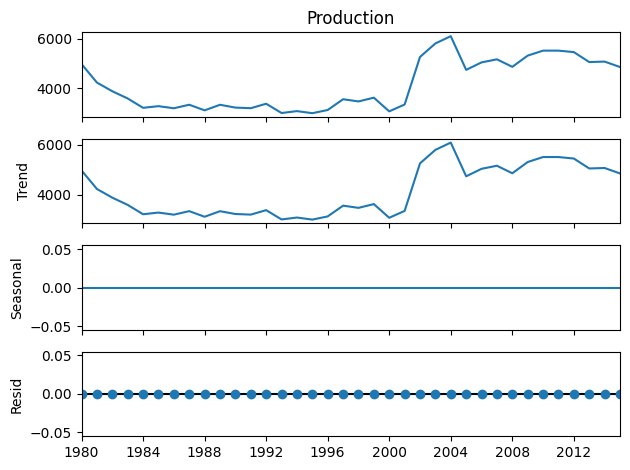

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 300)               362400    
                                                                 
 dense_19 (Dense)            (None, 1)                 301       
                                                                 
Total params: 362701 (1.38 MB)
Trainable params: 362701 (1.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
24/24 [==============================] - 2s 10ms/step - loss: 0.0970
Epoch 2/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0719
Epoch 3/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0634
Epoch 4/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0620
Epoch 5/50
24/24 [==============================] - 0s 9ms/step - loss: 0.0598
Epoch 6/50
24/24 

<ipython-input-1929-566c00cb91b2>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


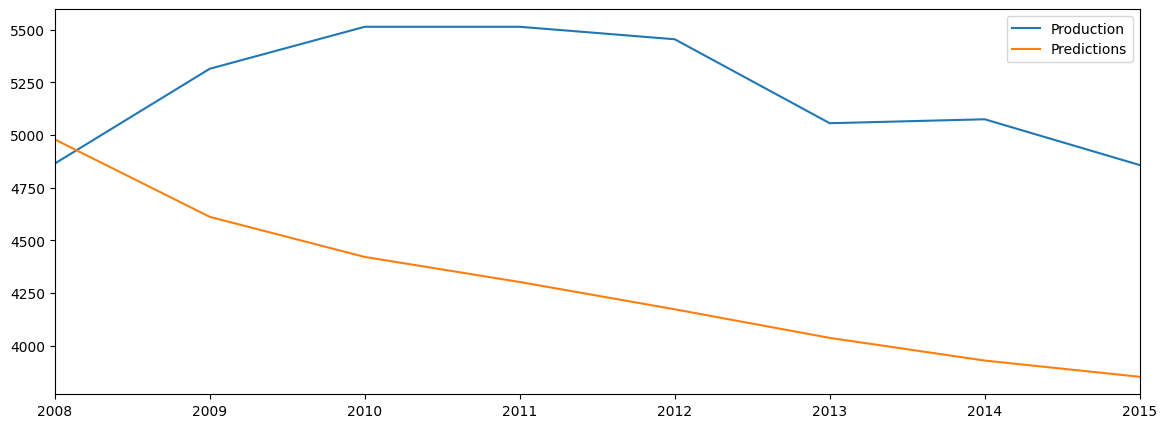

RMSE: 1011.327394219693


In [1929]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

# Charger les données
file_path = 'cleaned_production.csv'
df = pd.read_csv(file_path, encoding='latin1')

# Corriger les noms de colonnes mal interprétés
df.columns = ['Year', 'Production']

# Convertir 'Year' en datetime et le définir comme index
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# Créer un nouvel index annuel et réindexer le DataFrame pour inclure toutes les années
new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='AS')
df = df.reindex(new_index)

# Remplir les valeurs manquantes (si nécessaire)
df['Production'].fillna(method='ffill', inplace=True)

# Définir la fréquence sur le début de l'année (AS)
df.index.freq = 'AS'

# Tracer les données
df.plot(figsize=(12,6))
plt.ylabel('Production (Million DHs)')
plt.xlabel('Year')
plt.show()

# Décomposer la série temporelle
results = seasonal_decompose(df['Production'])
results.plot()
plt.show()

# Séparer les données en ensembles d'entraînement et de test
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Normaliser les données
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Définir le générateur
n_input = 4  # Utiliser 2 ans pour prédire l'année suivante
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

# Définir le modèle
model = Sequential()
model.add(LSTM(300, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Résumé du modèle
model.summary()

# Ajuster le modèle
model.fit(generator, epochs=50)

# Faire des prédictions
last_train_batch = scaled_train[-n_input:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(scaled_test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

# Inverser la transformation des prédictions
true_predictions = scaler.inverse_transform(test_predictions)

# Préparer le DataFrame de test
test['Predictions'] = true_predictions

# Tracer les résultats
test.plot(figsize=(14, 5))
plt.show()

# Calculer le RMSE
rmse = sqrt(mean_squared_error(test['Production'], test['Predictions']))
print(f'RMSE: {rmse}')

##Analyse Comparative (Nouvelles valeurs sont utilisées pour but de comparaison)
Nous allons maintenant comparer les prévisions de la consommation, de la contribution et de la production sur le même graphique pour estimer la demande future.


### 1. Normalisation des Valeurs
Pour rendre les courbes comparables, nous allons normaliser les valeurs de chaque série de données.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=464.847, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=436.321, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=446.605, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=545.156, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=437.213, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=437.338, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=439.250, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.586 seconds
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.512, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52.020, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=52.429, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=50.430, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=53.878, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.449 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=114.443, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=155.799, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=118.765, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=131.541, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=246.075, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=112.605, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=114.575, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=114.393, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=114.305, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=115.802, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=117.919, Time=0.05 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 1.322 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

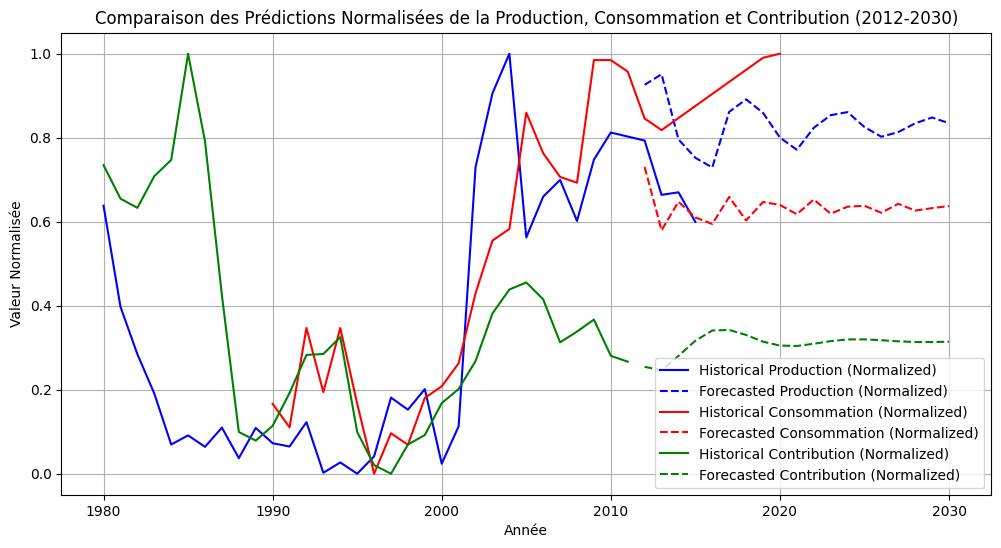

In [1930]:
# Analyse Comparative

# Reprendre l'importation des données nettoyées
df_production = pd.read_csv("/content/cleaned_production.csv")
df_consommation = pd.read_csv("/content/cleaned_consommation.csv")
df_contribution = pd.read_csv("/content/cleaned_contribution.csv")

# Définir l'index des DataFrames sur la colonne 'Année'
df_production.set_index('Année', inplace=True)
df_consommation.set_index('Année', inplace=True)
df_contribution.set_index('Année', inplace=True)

# Fonction pour analyser les données, former le modèle et faire des prédictions
def process_data(df, column_name):
    # Diviser les données en ensembles d'entraînement et de test basés sur l'année 2009
    train_df = df[df.index < 2008]
    test_df = df[df.index >= 2008]

    # Utiliser auto_arima pour trouver le meilleur modèle ARIMA
    stepwise_fit = auto_arima(train_df[column_name], trace=True, suppress_warnings=True)

    # Former le modèle ARIMA en utilisant les meilleurs paramètres trouvés par auto_arima
    model = ARIMA(train_df[column_name], order=(5,1,0))
    model_fit = model.fit()

    # Faire des prédictions pour l'ensemble de test
    predictions = model_fit.forecast(steps=len(test_df))

    # Prévisions futures jusqu'en 2030
    forecast_steps = 2030 - 2011
    arima_full_forecast = model_fit.get_forecast(steps=forecast_steps)
    future_pred = arima_full_forecast.predicted_mean

    return train_df, test_df, predictions, future_pred

# Traiter les trois séries de données
train_production, test_production, pred_production, future_production = process_data(df_production, 'Production')
train_consommation, test_consommation, pred_consommation, future_consommation = process_data(df_consommation, 'Consommation')
train_contribution, test_contribution, pred_contribution, future_contribution = process_data(df_contribution, 'Pourcentage')

# Normaliser les valeurs pour chaque série de données
scaler_production = MinMaxScaler()
scaler_consommation = MinMaxScaler()
scaler_contribution = MinMaxScaler()

df_production['production_norm'] = scaler_production.fit_transform(df_production[['Production']])
df_consommation['Consommation_norm'] = scaler_consommation.fit_transform(df_consommation[['Consommation']])
df_contribution['Pourcentage_norm'] = scaler_contribution.fit_transform(df_contribution[['Pourcentage']])

future_production_norm = scaler_production.transform(future_production.values.reshape(-1, 1))
future_consommation_norm = scaler_consommation.transform(future_consommation.values.reshape(-1, 1))
future_contribution_norm = scaler_contribution.transform(future_contribution.values.reshape(-1, 1))

# Créer un index pour les prédictions futures
future_index = pd.RangeIndex(start=2012, stop=2031, step=1)

# Tracer les courbes normalisées sur un seul graphique
plt.figure(figsize=(12, 6))

# Production
plt.plot(df_production.index, df_production['production_norm'], label='Historical Production (Normalized)', color='blue')
plt.plot(future_index, future_production_norm, label='Forecasted Production (Normalized)', color='blue', linestyle='dashed')

# Consommation
plt.plot(df_consommation.index, df_consommation['Consommation_norm'], label='Historical Consommation (Normalized)', color='red')
plt.plot(future_index, future_consommation_norm, label='Forecasted Consommation (Normalized)', color='red', linestyle='dashed')

# Contribution
plt.plot(df_contribution.index, df_contribution['Pourcentage_norm'], label='Historical Contribution (Normalized)', color='green')
plt.plot(future_index, future_contribution_norm, label='Forecasted Contribution (Normalized)', color='green', linestyle='dashed')

# Paramètres du graphique
plt.xlabel('Année')
plt.ylabel('Valeur Normalisée')
plt.title('Comparaison des Prédictions Normalisées de la Production, Consommation et Contribution (2012-2030)')
plt.legend()
plt.grid(True)
plt.show()
